# <center>**股票行业聚类划分** </center> 
<center>授课老师：王雄</center>

<center>2019023014  黄子珊</center>

随着时代迅猛地发展，现存行业越来越多，且趋近复杂。可能几年前所划分的行业已不适用于现在的划分。所以我们将尝试对股票市场的行业进行重新划分，使其更加贴合现在的市场与行情。

在本次的划分中，我们选定了沪深$300$加中证$500$作为股票池，选取$2019-01-01$到$2020-12-31$两年时间作为聚类时间段，然后对股票进行聚类，完成行业的重新划分。由于时间段较长，所提取出的特征较多，于是我们决定在聚类之前，先采用$PCA降维的方法减少变量，再采用$k-means$对样品进行聚类。

具体实现方法如下：
对于股票池中的股票，若样本时间序列长度大于$10$，则先用主成分分析法提取$10$个主成分，然后再用$k-means$聚类，否则直接进行$k-means$聚类。在这个过程中，设置相关系数阈值，以控制聚类情况的好坏。随后计算每一个类别的内部平均相关系数，对相关系数小于阈值的类进行二分聚类，直到分成相关系数达到阈值。同时可设置每个类别内部成分股的最小数目，使其内部的股票数量大于要求的最小数目。若以上操作均无法满足时，则将该股舍去，以达到聚类的紧密型。

我们将对股票池做一、二、三级行业的划分。由于每次划分的大小和类的数量是不同的，我们可以通过相应调整阈值和最小成分股数目以达到最佳聚类效果，同时使每个类别的股票数目不至于过少。


In [2]:
### 导入相关库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.charts import *


from datetime import datetime,timedelta
#PCA降维+Kmeans聚类
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy import stats



In [3]:
#忽略warning的输出
import warnings

warnings.filterwarnings('ignore')

[toc]
## 1. 函数定义

### 定义获取股票列表函数

In [113]:
def Regress(x,y):
    k,d,r,a,b=stats.linregress(x,y)
    return 1-r**2

def GetStockList(curdate=None, startDate=None, reday=None, market=None):
    if (market is None):
        b = get_all_securities(types=['stock'], date=curdate).display_name
        stockList = b.index.values.tolist()
        names = b.values.tolist()
    else:
        stockList = get_index_stocks(market, date=curdate)
        names = []
        for i in stockList:
            names.append(get_security_info(i).display_name)

    flag = i = 0
    length = len(stockList)
    while (flag < length):
        if ('S' in names[i]):
            del (stockList[i])
            del (names[i])
            i -= 1
        flag += 1
        i += 1
    temp = get_price(stockList, start_date=startDate, end_date=curdate,
                     frequency='1d', fields='close', skip_paused=False, fq='pre', count=reday).close.dropna(axis=1,
                                                                                                            how='any')
    stockList = list(temp.columns.values)
    return stockList


### 定义计算相关系数矩阵函数

In [95]:
def GetCorr(classChange):
    correlation = []
    for price in classChange:
        cont = 0
        corr = 0
        priceArray = pd.DataFrame(np.array(price).T).corr().values
        for i in range(len(price)-1):
            for j in range(i+1,len(price)):
                if(priceArray[i][j]!=priceArray[i][j]):
                    corr += 0
                    cont += 0
                else:
                    corr += priceArray[i][j]
                    cont += 1
        if(cont != 0):
            correlation.append(corr/cont)
            
    if(len(correlation)==0):
        return correlation,0
    else:
        return correlation,np.mean(correlation)

In [96]:
def Cluster(stockList,clusterNum,minNum,startDate=None,endDate=None,count=None,feq=0):
    price = get_price(stockList, start_date=startDate, end_date=endDate, 
                        frequency=str(feq+1)+'d',fields='close',skip_paused=False,
                      fq='pre',count=count).close.dropna(axis=1,how='any')
    price = price.values.T
    
    change = []
    for i in price:
        change.append(np.log(i[1:]/i[:-1]))
    #获取收盘价
    dataMat = mat(change)
    #调用sklearn中的PCA，其中主成分有10列
    if(len(change[0])>10):
        pca_sk = PCA(n_components=(10))
        #利用PCA进行降维，数据存在newMat中
        newMat = pca_sk.fit_transform(dataMat)
    else:
        newMat = dataMat            
    #利用KMeans进行聚类，分为n类
    kmeans = KMeans(clusterNum,random_state=0).fit(newMat)
    #labels为分类的标签
    labels = kmeans.labels_
    #score = metrics.silhouette_score(dataMat, labels) 
    cluster = [[] for i in range(clusterNum)]
    for i in range(len(labels)):
        cluster[labels[i]].append(stockList[i])
    #删除长度小于n的类
    flag = 0
    i = 0
    length = len(cluster)
    while(flag < length):
        if(len(cluster[i])<minNum):
            del(cluster[i])
            i -= 1
        i += 1
        flag += 1
    stockClass = cluster
    return stockClass



### 定义聚类函数

In [97]:
def Classify(cluster,stockList,limit,minNum,minClus,startDate=None,endDate=None,count=None,feq=0):
    if(minClus > 0):
        stockClass = Cluster(stockList,minClus,minNum,startDate=startDate,endDate=endDate,count=count,feq=feq)
        minClus = -1
    else:
        stockClass = Cluster(stockList,2,minNum,startDate=startDate,endDate=endDate,count=count,feq=feq)
    
    gprice = []
    gchange = []
    
    for i in stockClass:
        temp = get_price(i, start_date=startDate, end_date=endDate, 
                            frequency=str(feq+1)+'d',fields='close',skip_paused=False,
                          fq='pre',count=count).close.dropna(axis=1,how='any')
        temp = temp.values.T
        gprice.append(temp)
        change = []
        for j in temp:
            change.append(np.log(j[1:]/j[:-1]))
        gchange.append(change)
            
    score = []
    reclusterList = []
    score,meanScore = GetCorr(gchange)
    
    if(len(score)!=1):
        score = score[:len(stockClass)]
        for j in range(len(score)):
            if(score[j] <= limit):
                if(len(stockClass[j])>minNum):
                    reclusterList.append(stockClass[j])
            else:
                cluster.append(stockClass[j])

    if(len(reclusterList)!=0):
        for i in reclusterList:
            cluster = Classify(cluster,i,limit,minNum,minClus,startDate=startDate,endDate=endDate,count=count,feq=feq)
    return cluster


### 可视化聚类结果函数

In [98]:
def DisplayClass(cluster,stockList,limit,minNum,minClus,startDate=None,endDate=None,outDate=None,count=None,feq=0):
    cluster = Classify(cluster,stockList,limit,minNum,minClus,startDate=startDate,endDate=endDate,count=count,feq=feq)

    gprice = []
    gchange = []
    for i in cluster:
        temp = get_price(i,start_date=startDate,end_date=endDate, 
                      frequency=str(feq+1)+'d', fields='close', skip_paused=False, fq='pre',count=count).close
        date = list(temp.index)
        temp = temp.values.T
        gprice.append(temp)
        tempChange = []
        for j in temp:
            tempChange.append(np.log(j[1:]/j[:-1]))
        gchange.append(tempChange)

    corr,meanCorr = GetCorr(gchange)
    
    stockPool = []
    stockChange = []
    for i in range(len(cluster)):
        for j in range(len(cluster[i])):
            stockPool.append(cluster[i][j])
            stockChange.append(gchange[i][j])
            
    delStocks = list(set(stockList)-set(stockPool))
    delName = []
    for i in delStocks:
        delName.append(get_security_info(i).display_name)
    
    delPrice = get_price(delStocks,start_date=startDate,end_date=endDate, 
                      frequency=str(feq+1)+'d', fields='close', skip_paused=False, fq='pre',count=count).close.values.T
    delPrice = sum(delPrice,axis = 0)
    deltemp = get_price(delStocks,start_date=datetime.strptime(endDate, "%Y-%m-%d")+timedelta(days=1),end_date=outDate, 
                frequency=str(feq+1)+'d', fields='close', skip_paused=False, fq='pre',count=count).close.values.T
    deltemp = deltemp.sum(axis=0)
    delPrice = np.hstack((delPrice,np.array(deltemp)))
    
    
    priceIndex = []
    for i in gprice:
        priceIndex.append(sum(i,axis=0))
    priceChange = []
    for i in priceIndex:
        priceChange.append(np.log(i[-1]/i[0]))
    rankIndex = list(np.argsort(priceChange))[::-1]
    rankPrice = np.array(priceIndex)[rankIndex]
    rankCluster = np.array(cluster)[rankIndex]
    rankChange = np.array(priceChange)[rankIndex]

    #画图
    futIndex = []
    for i in rankCluster:
        tempF = get_price(i, start_date=datetime.strptime(endDate, "%Y-%m-%d")+timedelta(days=1), end_date=outDate, 
              frequency=str(feq+1)+'d', fields='close', skip_paused=False, fq='pre').close
        tempFdate = list(tempF.index)
        tempF = tempF.values.T
        tempF = tempF.sum(axis=0)
        futIndex.append(tempF)
    edge = len(date)
    date += tempFdate
    allIndex = np.hstack((rankPrice,np.array(futIndex)))

    marketPrice = get_price('000001.XSHG', start_date=date[0], end_date=date[-1], 
                  frequency=str(feq+1)+'d', fields='close', skip_paused=False, fq='pre').close.values.T

    fig,ax = plt.subplots(figsize=(16,6))
    for i in range(len(allIndex)):
        ax.plot(date,allIndex[i]/allIndex[i][0],label='NO.%d class %d'%(i+1,len(rankCluster[i])))
#     ax.plot(date,marketPrice/marketPrice[0],linewidth=5,alpha=0.5,label='BentchMarket',color='black')
    ax.axvspan(date[edge-1],date[-1], color='pink', alpha=0.3)
    ax.set_title('Cluster Result')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

#     fig,ax = plt.subplots(figsize=(16,6))
#     generalIndex = allIndex.sum(axis=0)
#     ax.plot(date,generalIndex/generalIndex[0],label='MyStockPool',color='blue',linewidth=5)
#     ax.plot(date,marketPrice/marketPrice[0],linewidth=5,label='BentchMarket',color='black')
#     ax.axvspan(date[edge-1],date[-1], color='pink', alpha=0.3)
#     ax.set_title('MyStockPool VS BentchMarket')
#     ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
#     fig,ax = plt.subplots(figsize=(16,6))
#     generalIndex = allIndex.sum(axis=0)
#     ax.plot(date,delPrice/delPrice[0],label='DelStockPool',color='blue',linewidth=5)
#     ax.plot(date,marketPrice/marketPrice[0],linewidth=5,label='BentchMarket',color='black')
#     ax.axvspan(date[edge-1],date[-1], color='pink', alpha=0.3)
#     ax.set_title('DelStockPool VS BentchMarket')
#     ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    
#     for i in range(len(allIndex)):
#         fig,ax = plt.subplots(figsize=(16,6))
#         ax.plot(date,allIndex[i]/allIndex[i][0],label='NO.%d class %d'%(i+1,len(rankCluster[i])))
#         ax.plot(date,marketPrice/marketPrice[0],linewidth=5,alpha=0.5,label='BentchMarket',color='black')
#         ax.axvspan(date[edge-1],date[-1], color='pink', alpha=0.3)
#         ax.set_title('Cluster Result')
#         ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

    stockName = []
    stockCode = []
    stockLabel = []
    industryNum = []
    for i in range(len(rankCluster)):
        industryNum.append(len(rankCluster[i]))
        for j in range(len(rankCluster[i])):
            stockName.append(get_security_info(rankCluster[i][j]).display_name)
            stockCode.append(rankCluster[i][j])
            stockLabel.append(i+1)
    
    
    industryName = ['农林牧渔I','采掘I','化工I','钢铁I','有色金属I','电子I','家用电器I','食品饮料I','纺织服装I',
                '轻工制造I','医药生物I','公用事业I','交通运输I','房地产I','商业贸易I','休闲服务I','综合I',
                '建筑材料I','建筑装饰I','电气设备I','国防军工I','计算机I','传媒I','通信I','银行I','非银金融I','汽车I','机械设备I']

    industryCode =['801010', '801020', '801030', '801040', '801050', '801080', '801110', '801120', '801130', '801140', '801150', '801160', '801170', '801180', '801200', '801210', '801230', '801710',
                   '801720', '801730', '801740', '801750', '801760', '801770', '801780', '801790', '801880', '801890']

    swClass = []
    for i in industryCode:
        swClass.append(get_industry_stocks(i,date = '2020-12-31'))
    
    originInd = []
    for i in range(len(rankCluster)):
        for j in range(len(rankCluster[i])):
            flag = 0
            for k in range(len(swClass)):
                if(rankCluster[i][j] in swClass[k]):
                    flag = 1 
                    originInd.append(industryName[k])
                    break
            if(flag == 0):
                originInd.append('其他')
    
    stocksize = pd.DataFrame({'CODE':stockCode,
                         'NAME':stockName,
                         'LABEL':stockLabel,
                         '所属申万一级行业':originInd
                            })

    oversize = pd.DataFrame({
                            '行业个数': [len(cluster)],
                            '平均行业内相关系数':[meanCorr],
                            '总成分股数目':[len(stockPool)],
                            '已剔除':[len(delStocks)]
                            })

    industrysize = pd.DataFrame({
                            '成分股个数': industryNum,
                            '行业内相关系数':corr,
                            '样本内收益': rankChange
                            })

    delstocksize = pd.DataFrame({
                            '剔除的股票代码': delStocks,
                            '剔除的股票名称': delName
                            })
    
    
    #print(oversize)
    #print(industrysize)
    #print(delstocksize)
    #print(stocksize)
    
    return allIndex,rankCluster,stocksize,oversize,industrysize,delstocksize

### 行业内部构成函数

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts import Pie
#fig,ax = plt.subplots(int(len(stockClass)/4),4,figsize=(16,16))
def draw(stockClass):
    specialCode = []
    specialName = []
    specialOrigin = []
    specialNow = []
    specialCorrNew = []
    specialCorrOld = []
    for i in range(len(stockClass)):
        fracs = []
        labels = []
        others = 0
        classIndex = 0
        tempmax = 0
        for j in range(len(swClass)):
            pre = len(list(set(stockClass[i])&set(swClass[j])))/len(stockClass[i])
            if(pre>tempmax):
                classIndex = j
                tempmax = pre
            if(pre > 0.05):
                fracs.append(pre)
                labels.append(industryName[j])
            else:
                others += pre


        farInd = farIndIndex[classIndex]

        aprice = get_price(stockClass[i],start_date=startDate,end_date=endDate, 
                      frequency=str(feq+1)+'d', fields='close', skip_paused=False, 
                           fq='pre',count=count).close.values.T
        achange = []
        for j in aprice:
            achange.append(np.log(j[1:]/j[:-1]))

#         f,ax1 = plt.subplots(figsize = (10,10))
#         sns.heatmap(pd.DataFrame(np.array(achange).T,columns=stocksize[stocksize.LABEL==i+1].NAME.values).corr(), linewidths = 0.05, ax = ax1, cmap="rainbow")
#         ax1.set_title(stockNames[i])
#         ax1.set_xlabel('kind')
#         ax1.set_xticklabels([]) #设置x轴图例为空值
#         ax1.set_ylabel('kind')
#         plt.show()


        for j in stockClass[i]:
            price = get_price(j,start_date=startDate,end_date=endDate, 
                      frequency=str(feq+1)+'d', fields='close', skip_paused=False, 
                              fq='pre',count=count).close.values.T
            change = np.log(price[1:]/price[:-1])

            change = pd.Series(change)
            for k in range(len(swClass)):
                if(j in swClass[k]):
                    oldClass = swClass[k]
                    if '688689.XSHG' in oldClass:
                        oldClass.remove('688689.XSHG')
                    if '688350.XSHG' in oldClass:
                        oldClass.remove('688350.XSHG')
                    if '688669.XSHG' in oldClass:
                        oldClass.remove('688669.XSHG')
                    if '688628.XSHG' in oldClass:
                        oldClass.remove('688628.XSHG')
                    if '688688.XSHG' in oldClass:
                        oldClass.remove('688688.XSHG')
                    if '688680.XSHG' in oldClass:
                        oldClass.remove('688680.XSHG')
                    if '688607.XSHG' in oldClass:
                        oldClass.remove('688607.XSHG')
                    if '688687.XSHG' in oldClass:
                        oldClass.remove('688687.XSHG')


                    break


            temp = get_price(oldClass,start_date=startDate,end_date=endDate, 
                      frequency=str(feq+1)+'d', fields='close', skip_paused=False,
                             fq='pre',count=count).close.dropna(axis=1,how='any').values.T
            tempchange = []
            for l in temp:
                tempchange.append(np.log(l[1:]/l[:-1]))

            corrOld = 0
            cont = 0
            for l in tempchange:
                if(len(np.unique(list(l)))==1):
                    continue
                cj = pd.Series(l)
                corrOld += change.corr(cj)
                cont += 1
            corrOld /= cont

            temp = get_price(stockClass[i],start_date=startDate,end_date=endDate, 
                      frequency=str(feq+1)+'d', fields='close', skip_paused=False, 
                             fq='pre',count=count).close.dropna(axis=1,how='any').values.T
            tempchange = []
            for l in temp:
                tempchange.append(np.log(l[1:]/l[:-1]))

            corrNew = 0
            cont = 0
            for l in tempchange:
                if(len(np.unique(list(l)))==1):
                    continue
                cj = pd.Series(l)
                corrNew += change.corr(cj)
                cont += 1
            corrNew /= cont

            if(corrNew>corrOld and classIndex!=k and max(fracs)>0.4 and (k in farInd)):
                specialCode.append(j)
                specialName.append(get_security_info(j).display_name)
                specialOrigin.append(industryName[k])
                specialNow.append(str(i+1)+':'+stockNames[i])
                specialCorrNew.append(corrNew)
                specialCorrOld.append(corrOld)

        if(others!=0):
            fracs.append(others)
            labels.append('其他')
        plt.pie(x=fracs,labels= labels,autopct='%.0f%%',explode=None,shadow=None)
        plt.title(stockNames[i]+'组成成分')
        plt.show()
        
#         pie = Pie("股票池内行业分布图", title_pos='center')
#         pie.add(
#         "",
#         labels,
#         fracs,
#         radius=[40, 75],
#         label_text_color=None,
#         is_label_show=True,
#         is_more_utils=True,
#         legend_orient="vertical",
#         legend_pos="left",
#         )
        
#         pie.render(path = "pie1.html")
        
        print('成分股:'+str(len(stocksize[stocksize.LABEL==i+1].NAME))+'支')
        print(stocksize[stocksize.LABEL==i+1].NAME)
        print("—————————————————————————————————————————————————————")
    special = pd.DataFrame({'code':specialCode,'name':specialName,'申万所属':specialOrigin,
                            '与申万行业的相关系数':specialCorrOld,'现在所属':specialNow,'与现在所属的相关系数':specialCorrNew})

## 2. 一级聚类

我们所选择的重点观测股票池是沪深300+中证500。通过下图可以看到其净利润、总市值和个数数量在总市场中的占比。重点观测股票池覆盖全A 的26.2%个股，在全 A 市值占比为 46%，但是净利润在全市场中的占比高达86.01%
重点观测股票池覆盖全 A 的 30%个股，在全 A 市值占比为 83%，全面覆盖公募基金、北上 TOP300 重仓股，经筛选股票池共覆盖800只个股，占全部 A 股数量的 30%。

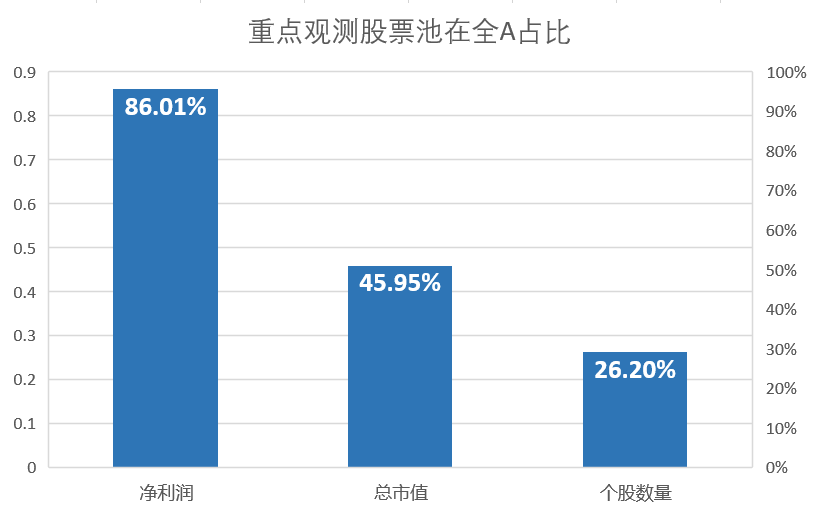

通过设置相关阈值和最小成分股的个数，我们将对所选取股票池进行一级聚类。（分为4类）

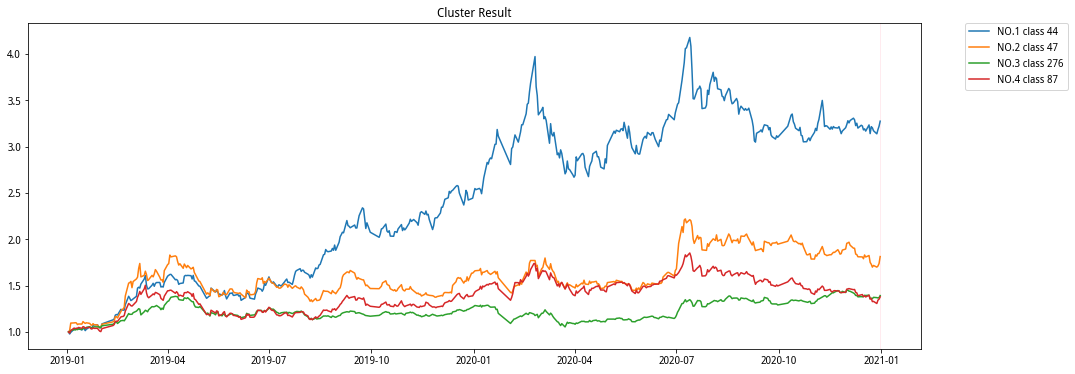

In [12]:
cluster=[]
limit=0.4
minNum=20
minClus=8
startDate = '2019-01-01'
endDate = '2020-12-31'
outDate = None
count = None 
feq = 0

stockList = GetStockList(startDate=startDate,curdate=endDate,reday=count,market='000300.XSHG')
stockList += GetStockList(startDate=startDate,curdate=endDate,reday=count,market='000905.XSHG')
allIndex,stockClass1,stocksize,oversize,industrysize,delstocksize = DisplayClass(cluster,stockList,limit,minNum,minClus,startDate=startDate,endDate=endDate,outDate=outDate,count=count,feq=feq)

In [30]:
oversize

,行业个数,平均行业内相关系数,总成分股数目,已剔除
0,4,0.502871,528,218


### 一级聚类后的行业散点图&Treemap

In [45]:
df = stockClass1

a = df[0]
b = pd.DataFrame(a)
b['行业']="科技类"
b['LABEL']=1
a1 = df[1]
b1 = pd.DataFrame(a1)
b1['行业']="金融类"
b1['LABEL']=2
a2 = df[2]
b2 = pd.DataFrame(a2)
b2['行业']="基建类"
b2['LABEL']=3
a3 = df[3]
b3 = pd.DataFrame(a3)
b3['行业']="消费类"
b3['LABEL']=4
b = b.append(b1, ignore_index=True)
b = b.append(b2, ignore_index=True)
b = b.append(b3, ignore_index=True)

c=b.rename(columns={0:'CODE'}) 
c['close'] = df_close
c.to_csv('close_1.csv')

In [42]:
df = get_price(c['CODE'][i], start_date='2019-12-31', end_date='2019-12-31', frequency='daily', fields=None, skip_paused=False, fq='pre', panel=True)
for i in range(454):
    a = get_price(c['CODE'][i], start_date='2019-12-31', end_date='2019-12-31', 
               frequency='daily', fields=None, skip_paused=False, fq='pre', panel=True)
    df = df.append(a, ignore_index=True)
df_close = df['close']


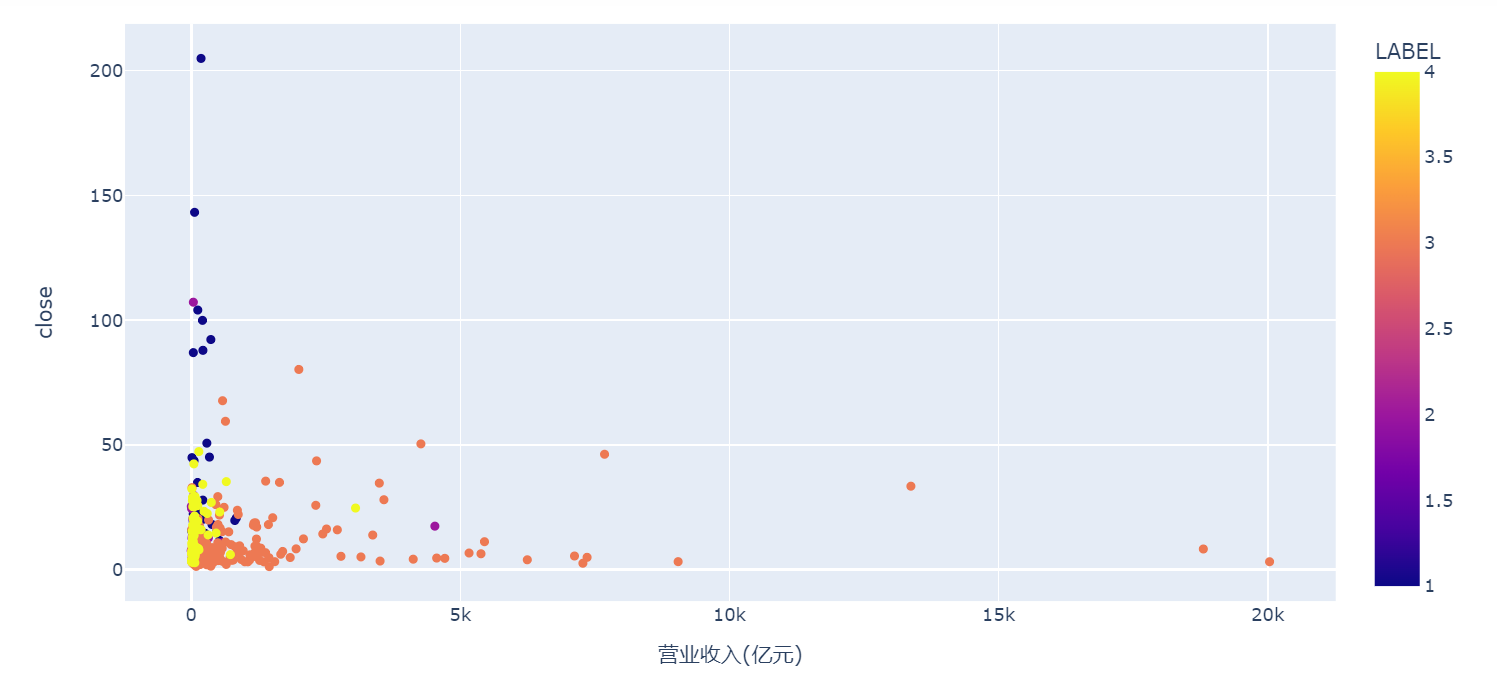

In [14]:
df1 = pd.read_csv('all_income_ini.csv',encoding = "gb2312")
df3 = df1[df1['截止日期']=="2021-9-30"]
df3=df3.rename(columns={"股票代码":'CODE'}) 
df3.head()

,Unnamed: 0,公司名称,CODE,公告日期,截止日期,净利润(亿元),营业收入(亿元)
300,300,中信泰富特钢集团股份有限公司,000708.XSHE,2021-10-12,2021-9-30,60.633141,742.164034
301,301,通策医疗股份有限公司,600763.XSHG,2021-10-15,2021-9-30,7.052794,21.363803
302,302,紫金矿业集团股份有限公司,601899.XSHG,2021-10-16,2021-9-30,145.329308,1689.755379
303,303,漳州片仔癀药业股份有限公司,600436.XSHG,2021-10-16,2021-9-30,20.608845,61.116476
304,304,东方财富信息股份有限公司,300059.XSHE,2021-10-16,2021-9-30,62.344040,40.509580


In [48]:
df4 = pd.merge(c,df3,on = "CODE")
df4.head()
df4.to_csv('stocksize1.csv')

In [ ]:
fig = px.treemap(df1, path=['行业', '公司名称'], values='营业收入(亿元)',
                  color='净利润(亿元)',
                  color_continuous_scale='Tealrose',
                  color_continuous_midpoint=0)
              
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

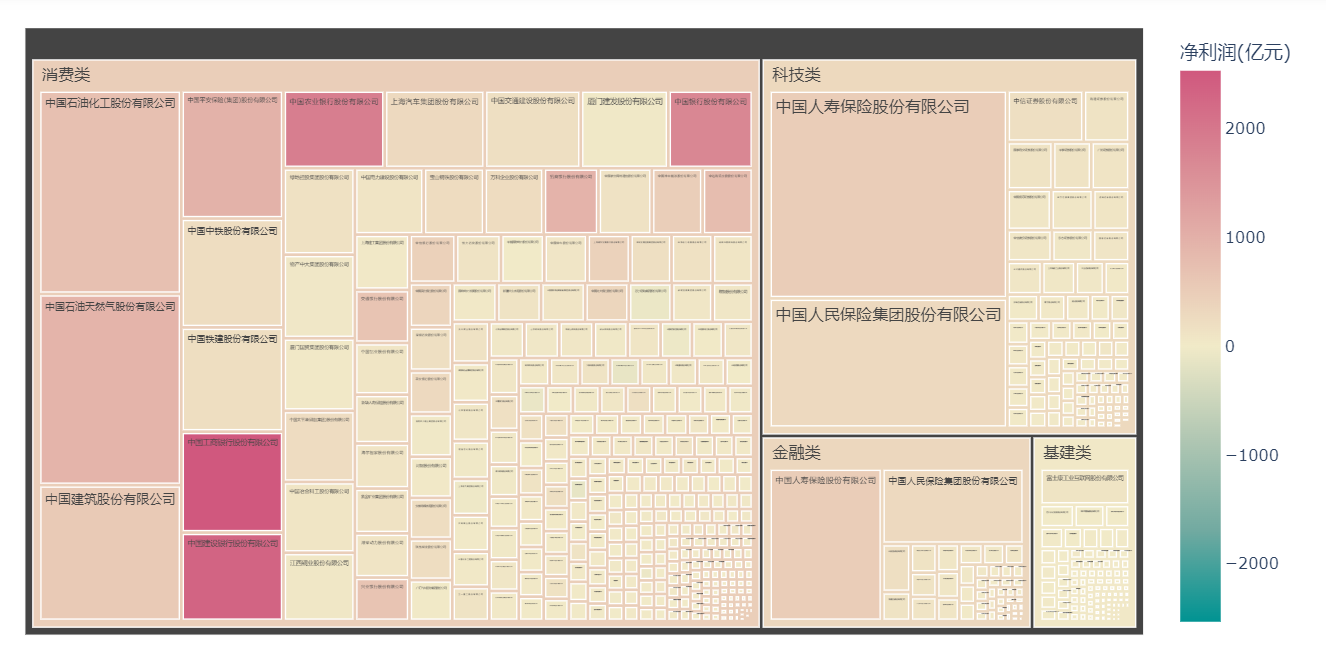

### 一级聚类后的行业相关系数图与饼状图

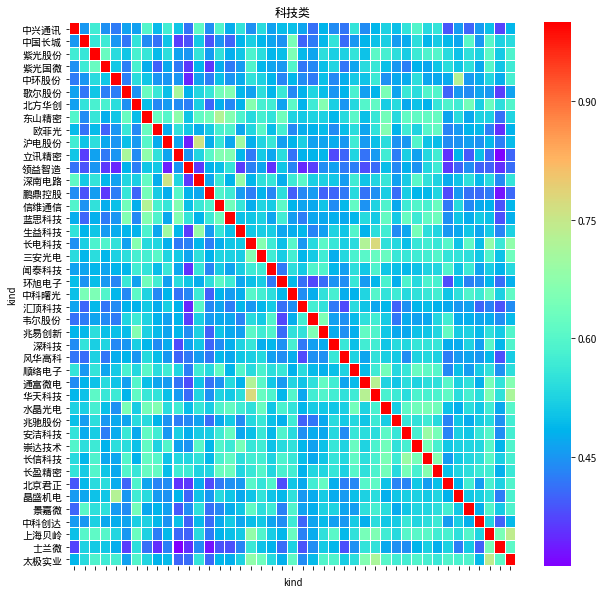

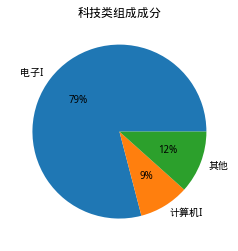

成分股:43支
0     中兴通讯
1     中国长城
2     紫光股份
3     紫光国微
4     中环股份
5     歌尔股份
6     北方华创
7     东山精密
8      欧菲光
9     沪电股份
10    立讯精密
11    领益智造
12    深南电路
13    鹏鼎控股
14    信维通信
15    蓝思科技
16    生益科技
17    长电科技
18    三安光电
19    闻泰科技
20    环旭电子
21    中科曙光
22    汇顶科技
23    韦尔股份
24    兆易创新
25     深科技
26    风华高科
27    顺络电子
28    通富微电
29    华天科技
30    水晶光电
31    兆驰股份
32    安洁科技
33    崇达技术
34    长信科技
35    长盈精密
36    北京君正
37    晶盛机电
38     景嘉微
39    中科创达
40    上海贝岭
41     士兰微
42    太极实业
Name: NAME, dtype: object
—————————————————————————————————————————————————————


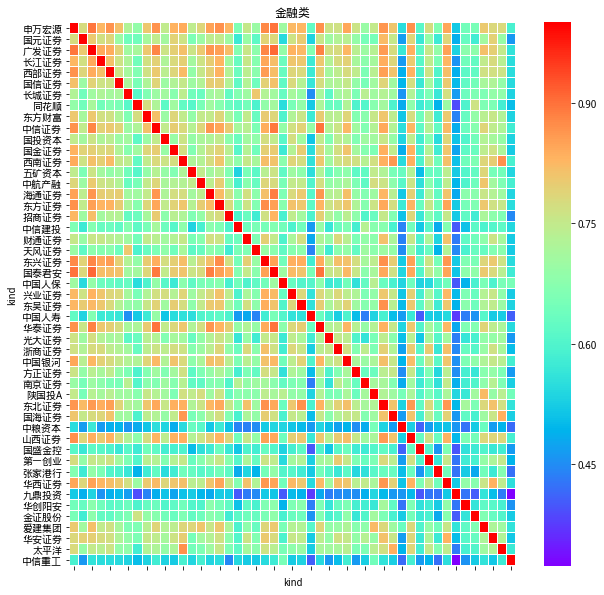

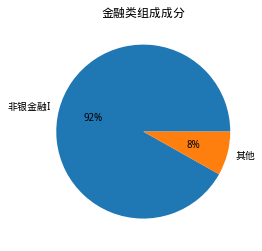

成分股:49支
43    申万宏源
44    国元证券
45    广发证券
46    长江证券
47    西部证券
48    国信证券
49    长城证券
50     同花顺
51    东方财富
52    中信证券
53    国投资本
54    国金证券
55    西南证券
56    五矿资本
57    中航产融
58    海通证券
59    东方证券
60    招商证券
61    中信建投
62    财通证券
63    天风证券
64    东兴证券
65    国泰君安
66    中国人保
67    兴业证券
68    东吴证券
69    中国人寿
70    华泰证券
71    光大证券
72    浙商证券
73    中国银河
74    方正证券
75    南京证券
76    陕国投A
77    东北证券
78    国海证券
79    中粮资本
80    山西证券
81    国盛金控
82    第一创业
83    张家港行
84    华西证券
85    九鼎投资
86    华创阳安
87    金证股份
88    爱建集团
89    华安证券
90     太平洋
91    中信重工
Name: NAME, dtype: object
—————————————————————————————————————————————————————


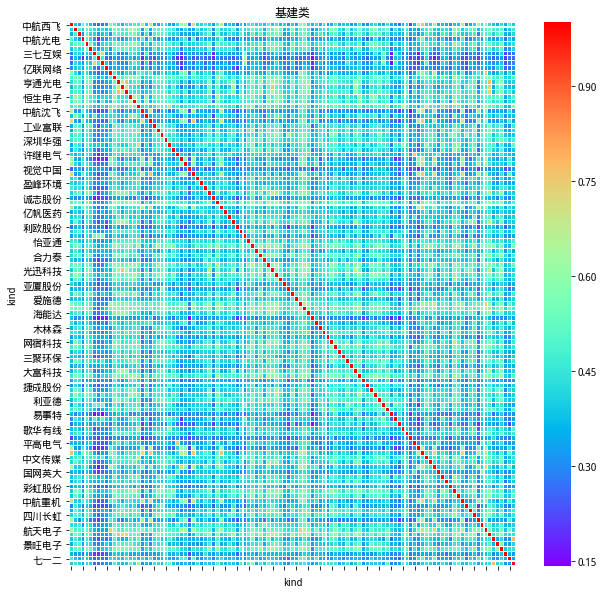

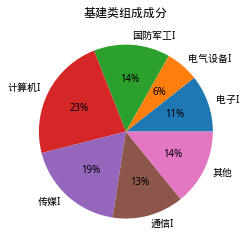

成分股:113支
92     中航西飞
93     浪潮信息
94     石基信息
95     中航光电
96     科大讯飞
97     大华股份
98     三七互娱
99     世纪华通
100    完美世界
101    亿联网络
102    中国卫星
103    航天信息
104    亨通光电
105    烽火通信
106    中天科技
107    恒生电子
108    用友网络
109    东方明珠
110    中航沈飞
111    宝信软件
112    航发动力
113    工业富联
114     三六零
115    深天马A
116    深圳华强
117    华数传媒
118    常山北明
119    许继电气
120    中兵红箭
121    航天发展
       ... 
175     汤姆猫
176    歌华有线
177    浙江东方
178    国网信通
179    平高电气
180    洪都航空
181    中航电子
182    中文传媒
183    华胜天成
184    北方导航
185    国网英大
186    浙数文化
187     新国脉
188    彩虹股份
189    东软集团
190    佳都科技
191    中航重机
192    东方通信
193     鹏博士
194    四川长虹
195    中航高科
196    东方电气
197    航天电子
198    长飞光纤
199     人民网
200    景旺电子
201    依顿电子
202    彤程新材
203     七一二
204     新华网
Name: NAME, Length: 113, dtype: object
—————————————————————————————————————————————————————


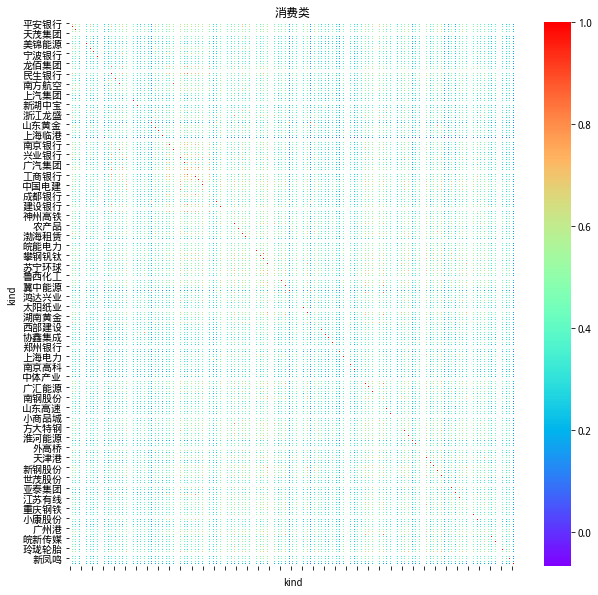

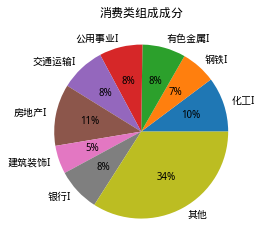

成分股:323支
205    平安银行
206     万科A
207    华侨城A
208    中联重科
209    潍柴动力
210    徐工机械
211    天茂集团
212    格力电器
213    金科股份
214     阳光城
215    恒逸石化
216    中信特钢
217    美锦能源
218    北新建材
219    中南建设
220    招商蛇口
221    苏宁易购
222    分众传媒
223    宁波银行
224    荣盛发展
225    金风科技
226    荣盛石化
227    老板电器
228    巨人网络
229    龙佰集团
230    万达电影
231    浦发银行
232    包钢股份
233    华能国际
234    华夏银行
       ... 
498    海南橡胶
499    小康股份
500    常熟银行
501    深圳燃气
502    西部矿业
503    中国西电
504    上海环境
505     广州港
506    桐昆股份
507    广深铁路
508    中国核建
509    潞安环能
510     郑煤机
511    皖新传媒
512     美凯龙
513    中远海发
514    辽港股份
515    凤凰传媒
516    金钼股份
517    玲珑轮胎
518    海南矿业
519    金隅集团
520    贵阳银行
521    德邦股份
522    和邦生物
523     新凤鸣
524    合盛硅业
525    莱克电气
526    东方时尚
527    吉祥航空
Name: NAME, Length: 323, dtype: object
—————————————————————————————————————————————————————


In [33]:
stockNames = ['科技类','金融类' ,'基建类', '消费类'] 
draw(stockClass1)

## 二级聚类

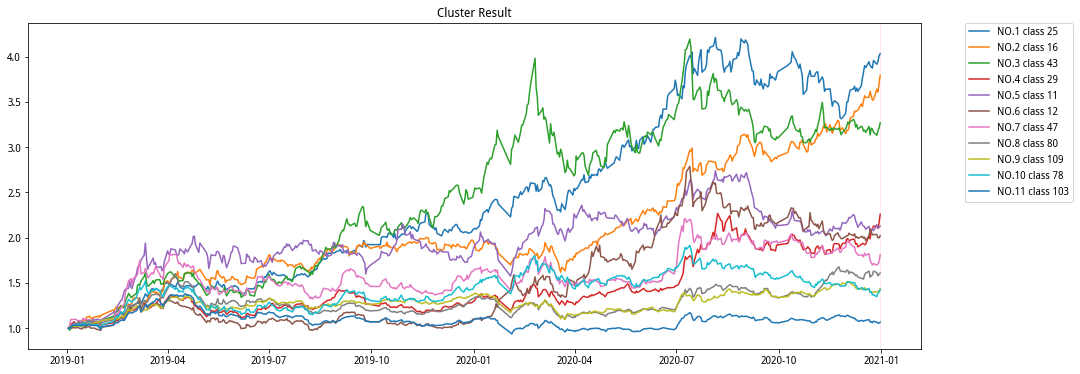

In [49]:
cluster=[]
limit=0.4
minNum=10
minClus=11
startDate = '2019-01-01'
endDate = '2020-12-31'
outDate = None
count = None 
feq = 0

stockList = GetStockList(startDate=startDate,curdate=endDate,reday=count,market='000300.XSHG')
stockList += GetStockList(startDate=startDate,curdate=endDate,reday=count,market='000905.XSHG')
allIndex,stockClass2,stocksize,oversize,industrysize,delstocksize = DisplayClass(cluster,stockList,limit,minNum,minClus,startDate=startDate,endDate=endDate,outDate=outDate,count=count,feq=feq)

In [125]:
oversize

,行业个数,平均行业内相关系数,总成分股数目,已剔除
0,11,0.500457,516,230


In [129]:
industrysize

,成分股个数,行业内相关系数,样本内收益
0,13,0.473651,1.566698
1,16,0.444109,1.333250
2,43,0.692354,1.184336
3,29,0.512766,0.814572
4,12,0.483797,0.764920
5,11,0.496029,0.712231
6,47,0.475141,0.593115
7,79,0.545187,0.475875
8,120,0.496504,0.356353
9,78,0.438656,0.352553


### 二级聚类后的行业散点图&Treemap

In [54]:
df = stockClass2

a = df[0]
b = pd.DataFrame(a)
b['行业']='医疗药业'
b['LABEL']=1
a1 = df[1]
b1 = pd.DataFrame(a1)
b1['行业']='必选消费'
b1['LABEL']=2
a2 = df[2]
b2 = pd.DataFrame(a2)
b2['行业']='电子科技'
b2['LABEL']=3
a3 = df[3]
b3 = pd.DataFrame(a3)
b3['行业']='国防建设'
b3['LABEL']=4
a4 = df[4]
b4 = pd.DataFrame(a4)
b['行业']='必选消费'
b4['LABEL']=5
a5 = df[5]
b5 = pd.DataFrame(a5)
b5['行业']='医疗服务'
b5['LABEL']=6
a6 = df[6]
b6 = pd.DataFrame(a6)
b6['行业']='证券'
b6['LABEL']=7
a7 = df[7]
b7 = pd.DataFrame(a7)
b7['行业']='基建地产'
b7['LABEL']=8
a8 = df[8]
b8 = pd.DataFrame(a8)
b8['行业']='生活服务'
b8['LABEL']=9
a9 = df[9]
b9 = pd.DataFrame(a9)
b9['行业']='消费电子'
b9['LABEL']=10
a10 = df[10]
b10 = pd.DataFrame(a10)
b10['行业']='机械设备'
b10['LABEL']=11


b = b.append(b1, ignore_index=True)
b = b.append(b2, ignore_index=True)
b = b.append(b3, ignore_index=True)
b = b.append(b4, ignore_index=True)
b = b.append(b5, ignore_index=True)
b = b.append(b6, ignore_index=True)
b = b.append(b7, ignore_index=True)
b = b.append(b8, ignore_index=True)
b = b.append(b9, ignore_index=True)
b = b.append(b10, ignore_index=True)


c=b.rename(columns={0:'CODE'}) 
c['close'] = df_close
# c.to_csv('close_1.csv')

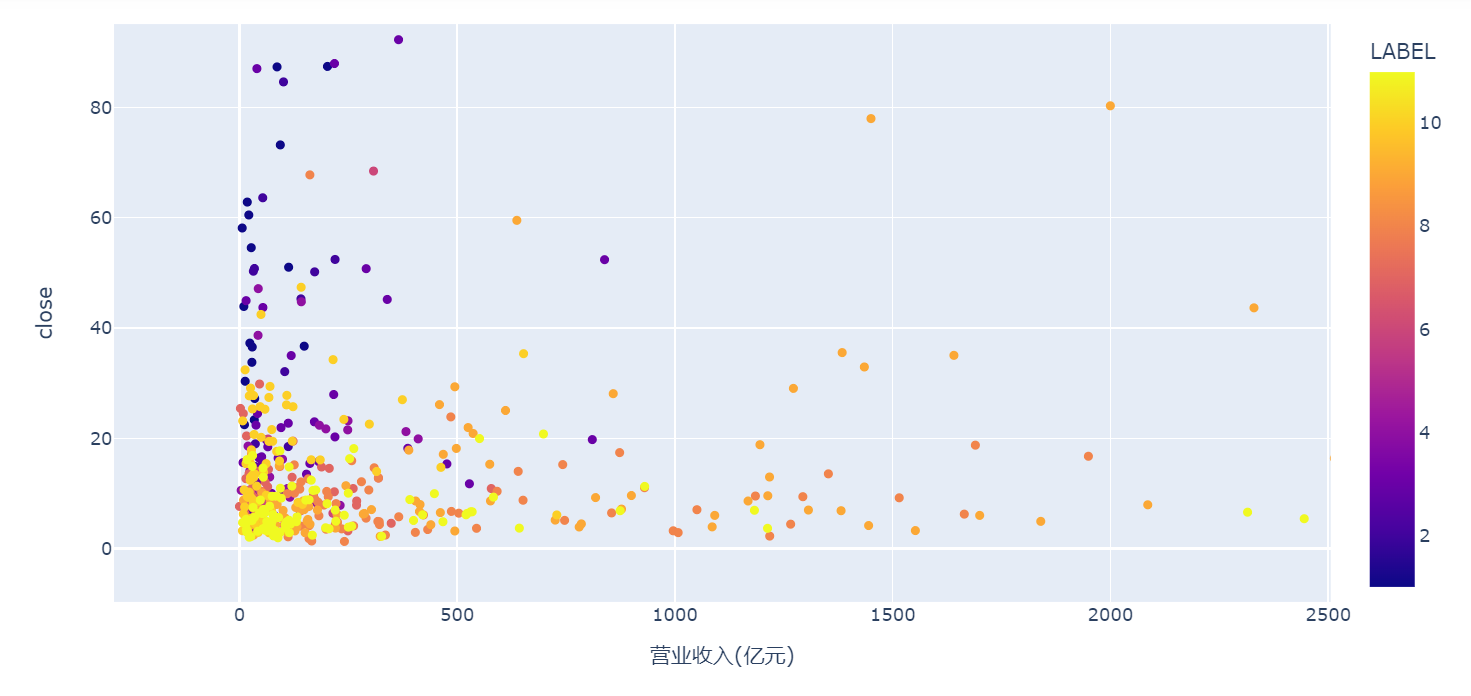

In [53]:
df = get_price(c['CODE'][i], start_date='2019-12-31', end_date='2019-12-31', frequency='daily', fields=None, skip_paused=False, fq='pre', panel=True)
for i in range(553):
    a = get_price(c['CODE'][i], start_date='2019-12-31', end_date='2019-12-31', 
               frequency='daily', fields=None, skip_paused=False, fq='pre', panel=True)
    df = df.append(a, ignore_index=True)
df_close = df['close']

In [127]:
df1 = pd.read_csv('all_income_ini.csv',encoding = "gb2312")
df3 = df1[df1['截止日期']=="2021-9-30"]
df3=df3.rename(columns={"股票代码":'CODE'}) 
df3.head()

,Unnamed: 0,公司名称,CODE,公告日期,截止日期,净利润(亿元),营业收入(亿元)
300,300,中信泰富特钢集团股份有限公司,000708.XSHE,2021-10-12,2021-9-30,60.633141,742.164034
301,301,通策医疗股份有限公司,600763.XSHG,2021-10-15,2021-9-30,7.052794,21.363803
302,302,紫金矿业集团股份有限公司,601899.XSHG,2021-10-16,2021-9-30,145.329308,1689.755379
303,303,漳州片仔癀药业股份有限公司,600436.XSHG,2021-10-16,2021-9-30,20.608845,61.116476
304,304,东方财富信息股份有限公司,300059.XSHE,2021-10-16,2021-9-30,62.344040,40.509580


In [55]:
df5 = pd.merge(c,df3,on = "CODE")
df5.head()
df5.to_csv('stocksize2.csv')

In [ ]:
fig = px.treemap(df1, path=['行业', '公司名称'], values='营业收入(亿元)',
                  color='净利润(亿元)',
                  color_continuous_scale='Tealrose',
                  color_continuous_midpoint=0)
              
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

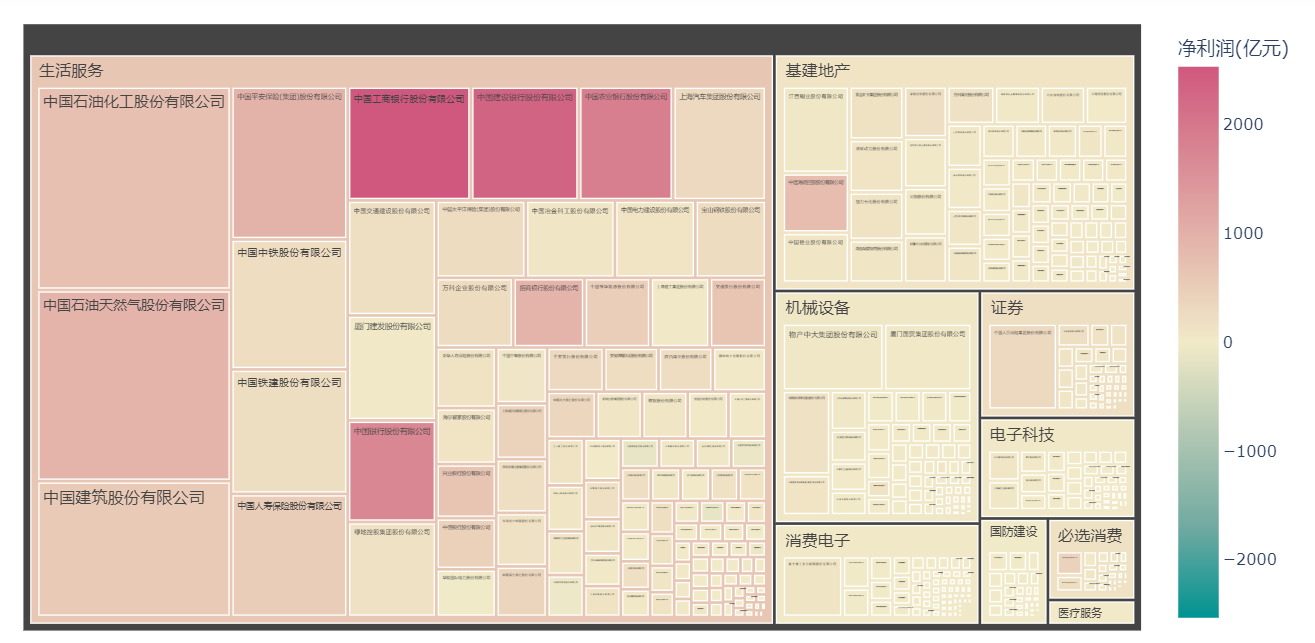

### 二级聚类后的行业饼状图

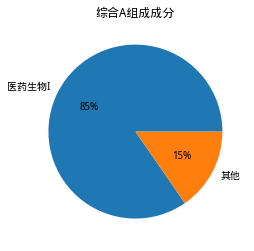

成分股:26支
0     长春高新
1     美年健康
2      广联达
3     康弘药业
4      凯莱英
5     乐普医疗
6     爱尔眼科
7     泰格医药
8     健帆生物
9     康泰生物
10    恒瑞医药
11    通策医疗
12    药明康德
13    安图生物
14    丽珠集团
15    美亚光电
16    大博医疗
17    我武生物
18    欧普康视
19    普利制药
20    人福医药
21    山东药玻
22     吉比特
23     珀莱雅
24    金域医学
25     老百姓
Name: NAME, dtype: object
—————————————————————————————————————————————————————


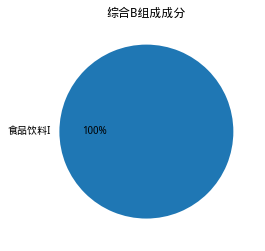

成分股:15支
26    泸州老窖
27    古井贡酒
28     五粮液
29    顺鑫农业
30    洋河股份
31    贵州茅台
32    青岛啤酒
33    山西汾酒
34     今世缘
35    燕京啤酒
36     张裕A
37    重庆啤酒
38     水井坊
39    迎驾贡酒
40     口子窖
Name: NAME, dtype: object
—————————————————————————————————————————————————————


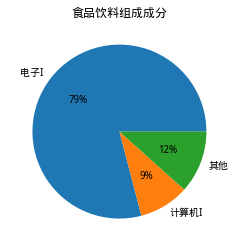

成分股:43支
41    中兴通讯
42    中国长城
43    紫光股份
44    紫光国微
45    中环股份
46    歌尔股份
47    北方华创
48    东山精密
49     欧菲光
50    沪电股份
51    立讯精密
52    领益智造
53    深南电路
54    鹏鼎控股
55    信维通信
56    蓝思科技
57    生益科技
58    长电科技
59    三安光电
60    闻泰科技
61    环旭电子
62    中科曙光
63    汇顶科技
64    韦尔股份
65    兆易创新
66     深科技
67    风华高科
68    顺络电子
69    通富微电
70    华天科技
71    水晶光电
72    兆驰股份
73    安洁科技
74    崇达技术
75    长信科技
76    长盈精密
77    北京君正
78    晶盛机电
79     景嘉微
80    中科创达
81    上海贝岭
82     士兰微
83    太极实业
Name: NAME, dtype: object
—————————————————————————————————————————————————————


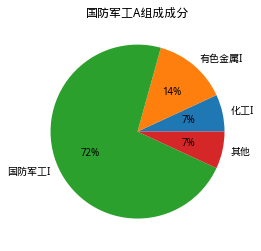

成分股:29支
84     中航西飞
85     中航光电
86     中国卫星
87     中国船舶
88     中国动力
89     中金黄金
90     山东黄金
91     中航沈飞
92     航发动力
93     中国重工
94     中兵红箭
95     航天发展
96     航发控制
97     银泰黄金
98     中航机电
99     湖南黄金
100    海格通信
101    光启技术
102    宏大爆破
103    光威复材
104    中直股份
105    洪都航空
106    中航电子
107    北方导航
108    中航重机
109    中航高科
110    航天电子
111    内蒙一机
112     七一二
Name: NAME, dtype: object
—————————————————————————————————————————————————————


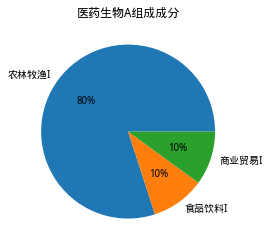

成分股:10支
113     新希望
114    正邦科技
115    牧原股份
116    温氏股份
117    天邦股份
118    圣农发展
119     大北农
120    益生股份
121    鹏都农牧
122    上海梅林
Name: NAME, dtype: object
—————————————————————————————————————————————————————


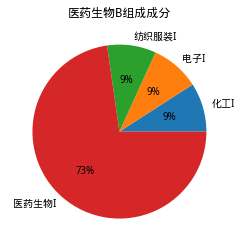

成分股:11支
123    高德红外
124    华大基因
125    海王生物
126    达安基因
127    东华能源
128    鱼跃医疗
129    蓝帆医疗
130    以岭药业
131    红日药业
132    哈药股份
133    际华集团
Name: NAME, dtype: object
—————————————————————————————————————————————————————


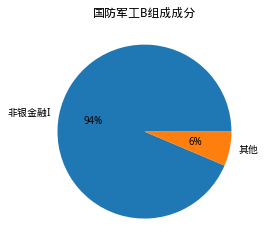

成分股:47支
134    申万宏源
135    国元证券
136    广发证券
137    长江证券
138    西部证券
139    国信证券
140    长城证券
141     同花顺
142    东方财富
143    中信证券
144    国投资本
145    国金证券
146    西南证券
147    五矿资本
148    中航产融
149    海通证券
150    东方证券
151    招商证券
152    中信建投
153    财通证券
154    天风证券
155    东兴证券
156    国泰君安
157    中国人保
158    兴业证券
159    东吴证券
160    华泰证券
161    光大证券
162    浙商证券
163    中国银河
164    方正证券
165    南京证券
166    陕国投A
167    东北证券
168    国海证券
169    中粮资本
170    山西证券
171    国盛金控
172    第一创业
173    华西证券
174    九鼎投资
175    华创阳安
176    金证股份
177    爱建集团
178    华安证券
179     太平洋
180    中信重工
Name: NAME, dtype: object
—————————————————————————————————————————————————————


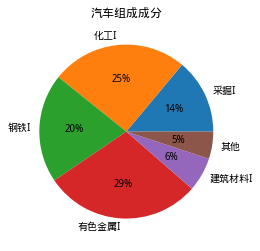

成分股:79支
181    中信特钢
182    美锦能源
183    荣盛石化
184    龙佰集团
185    包钢股份
186    北方稀土
187    中国巨石
188    恒力石化
189    浙江龙盛
190    江西铜业
191    中国铝业
192    中海油服
193    紫金矿业
194    中远海控
195    洛阳钼业
196     南玻A
197    中金岭南
198    冀东水泥
199    晨鸣纸业
200    安道麦A
201    攀钢钒钛
202    铜陵有色
203    河钢股份
204    韶钢松山
205    中色股份
206    云铝股份
207    太钢不锈
208    鲁西化工
209    天山股份
210    云南铜业
       ... 
230    兖矿能源
231    南山铝业
232    广晟有色
233    嘉化能源
234    南钢股份
235    酒钢宏兴
236    西藏珠峰
237    华阳股份
238    盛和资源
239    三友化工
240    华鲁恒升
241    扬农化工
242    驰宏锌锗
243    方大特钢
244    方大炭素
245    厦门钨业
246    华谊集团
247    新钢股份
248    华新水泥
249    淮北矿业
250    柳钢股份
251    重庆钢铁
252    中铝国际
253    西部矿业
254    桐昆股份
255    潞安环能
256    金钼股份
257    海南矿业
258     新凤鸣
259    合盛硅业
Name: NAME, Length: 79, dtype: object
—————————————————————————————————————————————————————


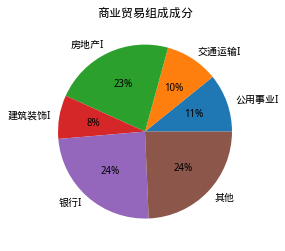

成分股:111支
260    平安银行
261     万科A
262    华侨城A
263    中联重科
264    天茂集团
265    格力电器
266    金科股份
267     阳光城
268    北新建材
269    中南建设
270    招商蛇口
271    宁波银行
272    荣盛发展
273    老板电器
274    浦发银行
275    白云机场
276    上海机场
277    华能国际
278    华夏银行
279    民生银行
280    宝钢股份
281    华能水电
282    华电国际
283    中国石化
284    南方航空
285    三一重工
286    招商银行
287    保利发展
288     葛洲坝
289    上汽集团
       ... 
341    鞍钢股份
342    海亮股份
343    塔牌集团
344    滨江集团
345    伟星新材
346    江阴银行
347    张家港行
348    郑州银行
349    建发股份
350    上海建工
351    城建发展
352    华发股份
353    山东高速
354    首开股份
355    海澜之家
356    蓝光发展
357    申能股份
358    信达地产
359    中华企业
360    锦江酒店
361    马钢股份
362    世茂股份
363    内蒙华电
364    无锡银行
365    常熟银行
366    深圳燃气
367    广深铁路
368    贵阳银行
369    东方时尚
370    吉祥航空
Name: NAME, Length: 111, dtype: object
—————————————————————————————————————————————————————


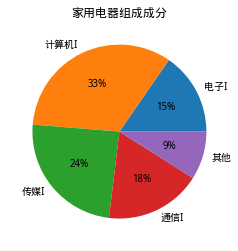

成分股:78支
371    浪潮信息
372    石基信息
373    科大讯飞
374    大华股份
375    三七互娱
376    世纪华通
377    完美世界
378    亿联网络
379    航天信息
380    亨通光电
381    烽火通信
382    中天科技
383    恒生电子
384    用友网络
385    宝信软件
386    工业富联
387     三六零
388    深天马A
389    深圳华强
390    华数传媒
391    常山北明
392    华工科技
393     新大陆
394    思源电气
395    国脉科技
396    利欧股份
397    广电运通
398    游族网络
399    二三四五
400     天融信
       ... 
419    华策影视
420    大富科技
421    东方国信
422    万达信息
423    捷成股份
424     易华录
425    华宇软件
426     利亚德
427    掌趣科技
428    旋极信息
429     易事特
430    昆仑万维
431     汤姆猫
432    歌华有线
433    国网信通
434    中文传媒
435    华胜天成
436    浙数文化
437     新国脉
438    彩虹股份
439    东软集团
440    佳都科技
441    东方通信
442     鹏博士
443    四川长虹
444    长飞光纤
445     人民网
446    景旺电子
447    依顿电子
448     新华网
Name: NAME, Length: 78, dtype: object
—————————————————————————————————————————————————————


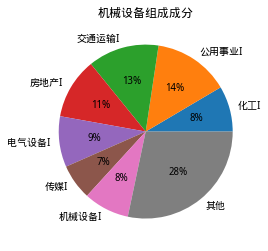

成分股:106支
449    徐工机械
450    巨人网络
451    上港集团
452    中国联通
453    新湖中宝
454    东方明珠
455    上海临港
456    君正集团
457    上海电气
458    招商轮船
459    神州高铁
460    深圳能源
461    中集集团
462    泛海控股
463     农产品
464    天健集团
465    东方盛虹
466    许继电气
467    渤海租赁
468      柳工
469    中天金融
470    皖能电力
471    万向钱潮
472    建投能源
473    吉林敖东
474    中山公用
475    宝新能源
476    苏宁环球
477    新兴铸管
478    启迪环境
       ... 
525    中储股份
526    东方集团
527    隧道股份
528    远东股份
529    石化油服
530    东方电气
531    亚泰集团
532    张江高科
533    江苏租赁
534    贵州燃气
535    重庆燃气
536    江苏有线
537    中材国际
538     唐山港
539    节能风电
540    中南传媒
541    中国一重
542    海南橡胶
543    小康股份
544    中国西电
545    上海环境
546     广州港
547    中国核建
548    皖新传媒
549     美凯龙
550    中远海发
551    辽港股份
552    凤凰传媒
553    金隅集团
554    和邦生物
Name: NAME, Length: 106, dtype: object
—————————————————————————————————————————————————————


In [16]:
stockNames = ['医疗药业','必选消费' ,'电子科技', '国防建设', '必选消费', 
              '医疗服务', '证券', '基建地产', '生活服务',
             '消费电子', '机械设备'] 
draw(stockClass2)

## 三级聚类

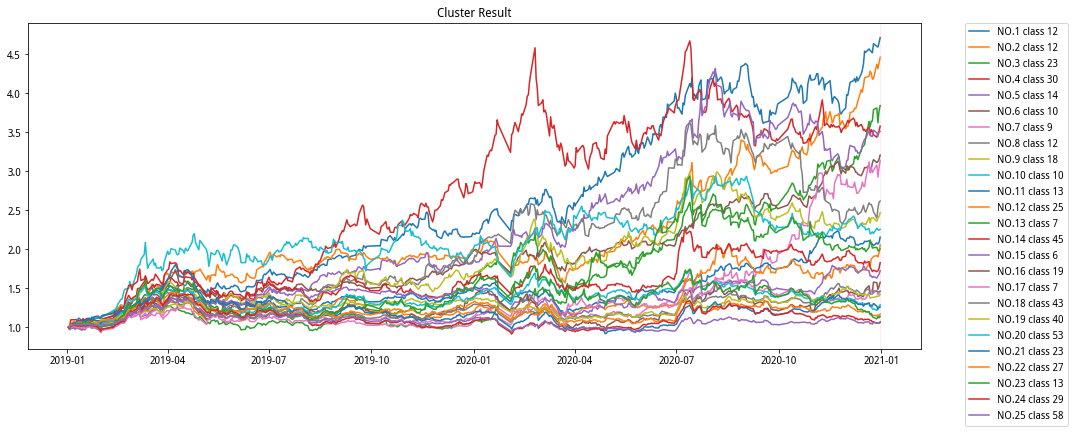

In [153]:
cluster=[]
limit=0.4
minNum=5
minClus=27
startDate = '2019-01-01'
endDate = '2020-12-31'
outDate = None
count = None 
feq = 0

stockList = GetStockList(startDate=startDate,curdate=endDate,reday=count,market='000300.XSHG')
stockList += GetStockList(startDate=startDate,curdate=endDate,reday=count,market='000905.XSHG')
allIndex,stockClass,stocksize,oversize,industrysize,delstocksize = DisplayClass(cluster,stockList,limit,minNum,minClus,startDate=startDate,endDate=endDate,outDate=outDate,count=count,feq=feq)

In [154]:
oversize

,行业个数,平均行业内相关系数,总成分股数目,已剔除
0,25,0.505718,558,188


In [151]:
from jqdata import finance
change = []
for i in industryCode:
    df=finance.run_query(query(finance.SW1_DAILY_PRICE).filter(finance.SW1_DAILY_PRICE.code==i).order_by(finance.SW1_DAILY_PRICE.date.desc()).limit(300)) 
    price = df.change_pct.values.T
    change.append(price)
corre = pd.DataFrame(np.array(change).T,columns=industryName).corr()
corr = corre.values
farIndIndex = []
farIndName = []
for i in corr:
    index = np.argsort(np.array(i))[:13]
    farIndIndex.append(index)
    farIndName.append(np.array(industryName)[index])

df = pd.DataFrame(farIndName,index = industryName,columns=range(13))

In [152]:
industryName = ['农林牧渔I','采掘I','化工I','钢铁I','有色金属I','电子I','家用电器I','食品饮料I','纺织服装I',
                '轻工制造I','医药生物I','公用事业I','交通运输I','房地产I','商业贸易I','休闲服务I','综合I',
                '建筑材料I','建筑装饰I','电气设备I','国防军工I','计算机I','传媒I','通信I','银行I','非银金融I','汽车I','机械设备I']

industryCode =['801010', '801020', '801030', '801040', '801050', '801080', '801110', '801120', '801130', '801140', '801150', '801160', '801170', '801180', '801200', '801210', '801230', '801710',
               '801720', '801730', '801740', '801750', '801760', '801770', '801780', '801790', '801880', '801890']

swClass = []
for i in industryCode:
    swClass.append(get_industry_stocks(i,date = '2020-12-31'))

### 三级聚类中各成分股的个数

Text(0.5, 1.0, '三级聚类中各成分股的个数')

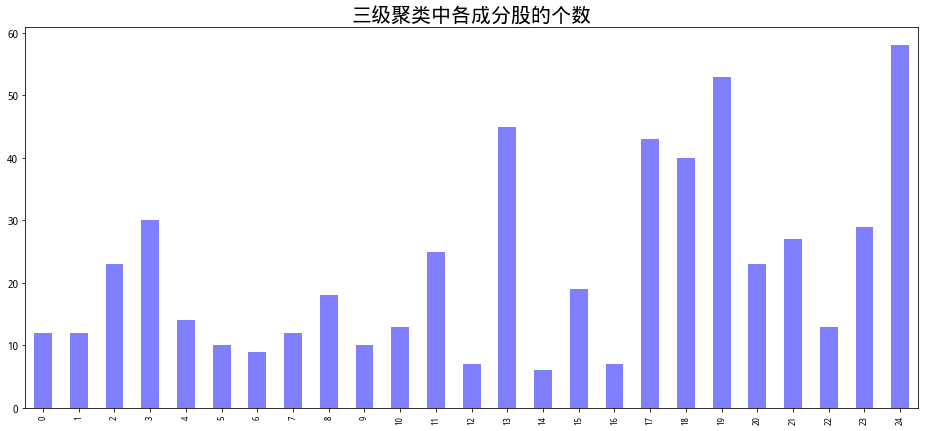

In [156]:
figure,axes=plt.subplots(figsize=(16,7))
industrysize['成分股个数'].plot(color='b', kind='bar',alpha=0.5)
plt.xticks(rotation = 90, fontsize=8)
plt.title("三级聚类中各成分股的个数",fontsize=20)

### 三级聚类后的行业Treemap

In [163]:
df = stockClass

a = df[0]
b = pd.DataFrame(a)
b['行业']='医药生物A'
a1 = df[1]
b1 = pd.DataFrame(a1)
b1['行业']='食品饮料'
a2 = df[2]
b2 = pd.DataFrame(a2)
b2['行业']='综合A'
a3 = df[3]
b3 = pd.DataFrame(a3)
b3['行业']='电子制造'
a4 = df[4]
b4 = pd.DataFrame(a4)
b['行业']='医药生物B'
a5 = df[5]
b5 = pd.DataFrame(a5)
b5['行业']='建材'
a6 = df[6]
b6 = pd.DataFrame(a6)
b6['行业']='汽车'
a7 = df[7]
b7 = pd.DataFrame(a7)
b7['行业']='传媒互娱'
a8 = df[8]
b8 = pd.DataFrame(a8)
b8['行业']='集成电子'
a9 = df[9]
b9 = pd.DataFrame(a9)
b9['行业']='农林牧渔A'
a10 = df[10]
b10 = pd.DataFrame(a10)
b10['行业']='家居服务'
a11 = df[11]
b11 = pd.DataFrame(a11)
b11['行业']='国防军工'
a12 = df[12]
b12 = pd.DataFrame(a12)
b12['行业']='制药产业'
a13 = df[13]
b13 = pd.DataFrame(a13)
b13['行业']='证券'
a14 = df[14]
b14 = pd.DataFrame(a14)
b14['行业']='旅游消费'
a15 = df[15]
b15 = pd.DataFrame(a15)
b15['行业']='有色金属'
a16 = df[16]
b16 = pd.DataFrame(a16)
b16['行业']='农林牧渔B'
a17 = df[17]
b17 = pd.DataFrame(a17)
b17['行业']='基建施工'
a18 = df[18]
b18 = pd.DataFrame(a18)
b18['行业']='银行'
a19 = df[19]
b19 = pd.DataFrame(a19)
b19['行业']='电子通讯'
a20 = df[20]
b20 = pd.DataFrame(a20)
b20['行业']='基建原料'
a21 = df[21]
b21 = pd.DataFrame(a21)
b21['行业']='房地产'
a22 = df[22]
b22 = pd.DataFrame(a22)
b22['行业']='电子科技'
a23 = df[23]
b23 = pd.DataFrame(a23)
b23['行业']='综合B'
a24 = df[24]
b24 = pd.DataFrame(a2)
b24['行业']='国有基建'



b = b.append(b1, ignore_index=True)
b = b.append(b2, ignore_index=True)
b = b.append(b3, ignore_index=True)
b = b.append(b4, ignore_index=True)
b = b.append(b5, ignore_index=True)
b = b.append(b6, ignore_index=True)
b = b.append(b7, ignore_index=True)
b = b.append(b8, ignore_index=True)
b = b.append(b9, ignore_index=True)
b = b.append(b10, ignore_index=True)
b = b.append(b11, ignore_index=True)
b = b.append(b12, ignore_index=True)
b = b.append(b13, ignore_index=True)
b = b.append(b14, ignore_index=True)
b = b.append(b15, ignore_index=True)
b = b.append(b16, ignore_index=True)
b = b.append(b17, ignore_index=True)
b = b.append(b18, ignore_index=True)
b = b.append(b19, ignore_index=True)
b = b.append(b20, ignore_index=True)
b = b.append(b21, ignore_index=True)
b = b.append(b22, ignore_index=True)
b = b.append(b23, ignore_index=True)
b = b.append(b24, ignore_index=True)

c=b.rename(columns={0:'CODE'}) 

In [166]:
df6 = pd.merge(c,df3,on = "CODE")
df6
# df6.to_csv('stocksize3.csv')

,CODE,行业,Unnamed: 0,公司名称,公告日期,截止日期,净利润(亿元),营业收入(亿元)
0,000661.XSHE,医药生物B,513,长春高新技术产业(集团)股份有限公司,2021-10-30,2021-9-30,32.882284,82.385252
1,002607.XSHE,医药生物B,580,中公教育科技股份有限公司,2021-10-30,2021-9-30,-8.909021,63.011941
2,002821.XSHE,医药生物B,354,凯莱英医药集团(天津)股份有限公司,2021-10-27,2021-9-30,6.948379,29.229860
3,300015.XSHE,医药生物B,340,爱尔眼科医院集团股份有限公司,2021-10-26,2021-9-30,21.717199,115.963099
4,300347.XSHE,医药生物B,321,杭州泰格医药科技股份有限公司,2021-10-23,2021-9-30,21.857211,33.950152
5,300529.XSHE,医药生物B,355,健帆生物科技集团股份有限公司,2021-10-27,2021-9-30,8.620648,17.818053
6,600763.XSHG,医药生物B,301,通策医疗股份有限公司,2021-10-15,2021-9-30,7.052794,21.363803
7,603259.XSHG,医药生物B,556,无锡药明康德新药开发股份有限公司,2021-10-30,2021-9-30,35.882438,165.213694
8,002901.XSHE,医药生物B,1187,大博医疗科技股份有限公司,2021-10-26,2021-9-30,4.715844,13.048886
9,300357.XSHE,医药生物B,1236,浙江我武生物科技股份有限公司,2021-10-27,2021-9-30,2.662944,6.197214


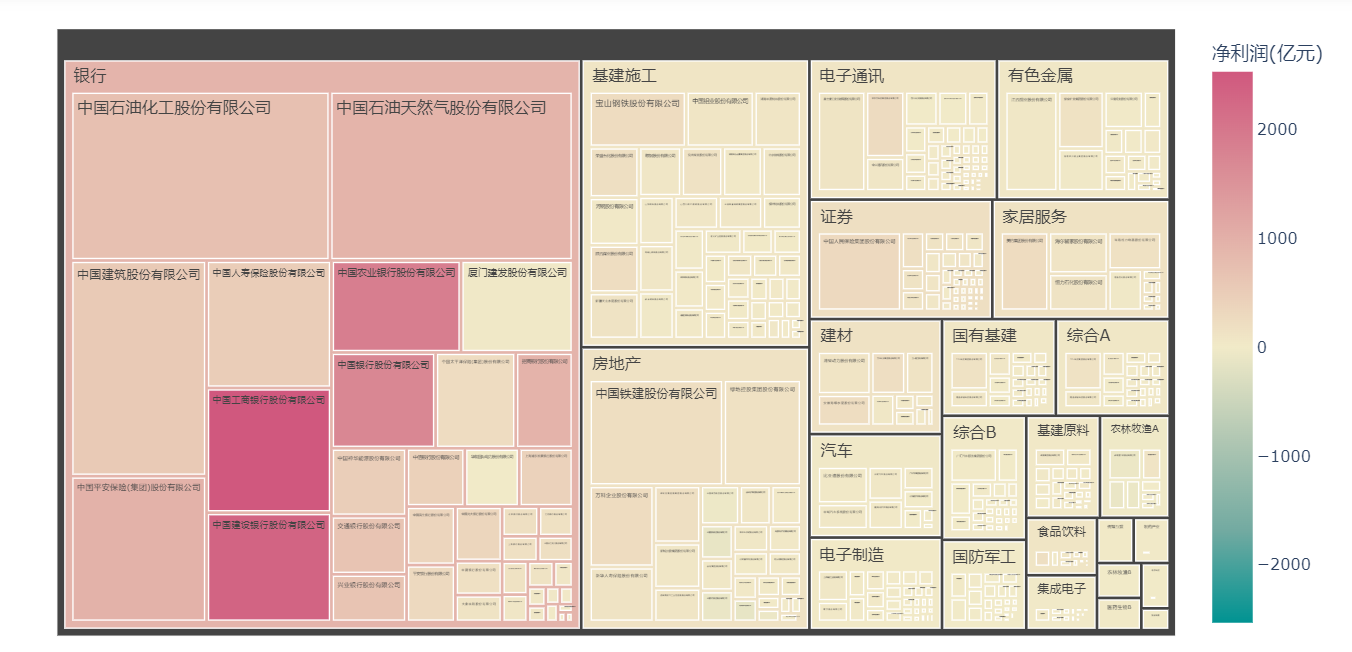

### 三级聚类后的行业饼状图

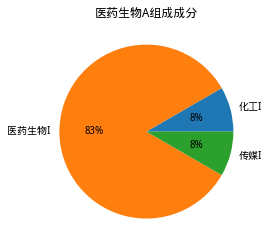

成分股:12支
0     长春高新
1     中公教育
2      凯莱英
3     爱尔眼科
4     泰格医药
5     健帆生物
6     通策医疗
7     药明康德
8     大博医疗
9     我武生物
10    欧普康视
11     珀莱雅
Name: NAME, dtype: object
—————————————————————————————————————————————————————


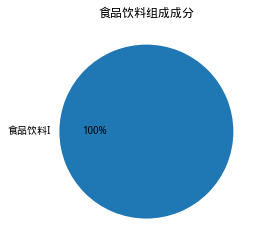

成分股:12支
12    泸州老窖
13    古井贡酒
14     五粮液
15    顺鑫农业
16    洋河股份
17    青岛啤酒
18    山西汾酒
19     今世缘
20    百润股份
21     水井坊
22    迎驾贡酒
23     口子窖
Name: NAME, dtype: object
—————————————————————————————————————————————————————


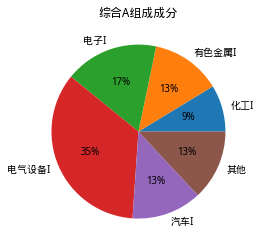

成分股:23支
24    TCL科技
25     三花智控
26     赣锋锂业
27     恩捷股份
28     亿纬锂能
29     通威股份
30     隆基股份
31     华友钴业
32     中国宝安
33     宁波华翔
34     横店东磁
35     国轩高科
36     天赐材料
37     德赛西威
38      特锐德
39      欣旺达
40     阳光电源
41     法拉电子
42     卧龙电驱
43     均胜电子
44     杉杉股份
45     宏发股份
46     拓普集团
Name: NAME, dtype: object
—————————————————————————————————————————————————————


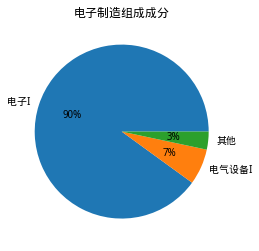

成分股:30支
47    中环股份
48    歌尔股份
49    北方华创
50    东山精密
51     欧菲光
52    沪电股份
53    立讯精密
54    领益智造
55    深南电路
56    鹏鼎控股
57    信维通信
58    蓝思科技
59    生益科技
60    长电科技
61    三安光电
62    闻泰科技
63    环旭电子
64    汇顶科技
65    韦尔股份
66    兆易创新
67    顺络电子
68    通富微电
69    华天科技
70    水晶光电
71    安洁科技
72    长信科技
73    长盈精密
74    北京君正
75    晶盛机电
76    中科创达
Name: NAME, dtype: object
—————————————————————————————————————————————————————


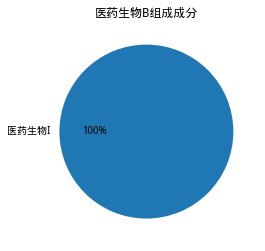

成分股:14支
77    华兰生物
78    智飞生物
79    沃森生物
80    康泰生物
81    天坛生物
82    复星医药
83    安图生物
84    丽珠集团
85    安科生物
86    迪安诊断
87    迈克生物
88    万孚生物
89    人福医药
90    金域医学
Name: NAME, dtype: object
—————————————————————————————————————————————————————


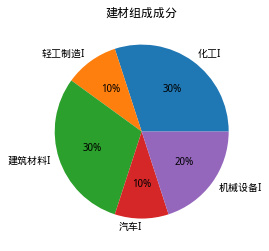

成分股:10支
91     中联重科
92     潍柴动力
93     北新建材
94     东方雨虹
95     三一重工
96     万华化学
97     海螺水泥
98     太阳纸业
99     华鲁恒升
100    扬农化工
Name: NAME, dtype: object
—————————————————————————————————————————————————————


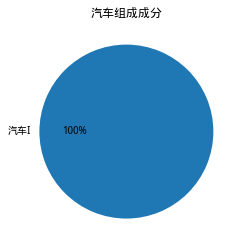

成分股:9支
101    长安汽车
102     比亚迪
103    华域汽车
104    广汽集团
105    长城汽车
106    东风汽车
107    福田汽车
108    江淮汽车
109    北汽蓝谷
Name: NAME, dtype: object
—————————————————————————————————————————————————————


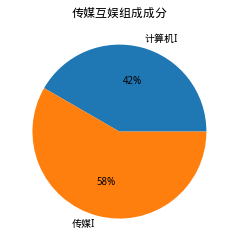

成分股:12支
110     广联达
111    三七互娱
112    世纪华通
113    完美世界
114    芒果超媒
115    宝信软件
116    游族网络
117    豆神教育
118    万达信息
119    华宇软件
120    昆仑万维
121     吉比特
Name: NAME, dtype: object
—————————————————————————————————————————————————————


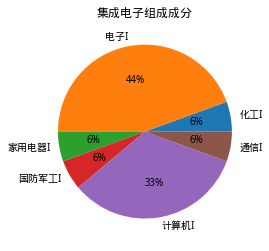

成分股:18支
122    中国长城
123    紫光股份
124    紫光国微
125    用友网络
126    中科曙光
127     深科技
128    风华高科
129    华工科技
130    太极股份
131    兆驰股份
132    杰赛科技
133    宏大爆破
134    崇达技术
135     景嘉微
136    上海贝岭
137    华胜天成
138     士兰微
139    太极实业
Name: NAME, dtype: object
—————————————————————————————————————————————————————


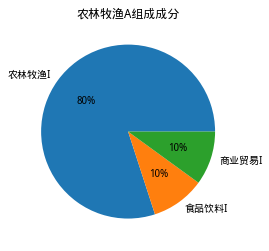

成分股:10支
140     新希望
141    正邦科技
142    牧原股份
143    温氏股份
144    天邦股份
145    圣农发展
146     大北农
147    益生股份
148    鹏都农牧
149    上海梅林
Name: NAME, dtype: object
—————————————————————————————————————————————————————


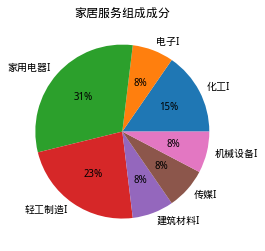

成分股:13支
150    美的集团
151    格力电器
152    恒逸石化
153    分众传媒
154    老板电器
155    恒力石化
156    海尔智家
157    欧派家居
158    伟星新材
159     索菲亚
160    豪迈科技
161    欧普照明
162    顾家家居
Name: NAME, dtype: object
—————————————————————————————————————————————————————


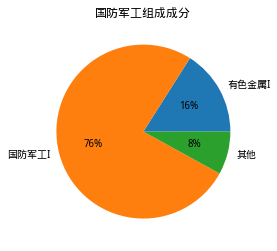

成分股:25支
163    中航西飞
164    中国卫星
165    中国船舶
166    中国动力
167    中金黄金
168    山东黄金
169    中航沈飞
170    航发动力
171    中国重工
172    中兵红箭
173    航天发展
174    航发控制
175    银泰黄金
176    中航机电
177    湖南黄金
178    光启技术
179    中直股份
180    洪都航空
181    中航电子
182    北方导航
183    中航重机
184    中航高科
185    航天电子
186    内蒙一机
187     七一二
Name: NAME, dtype: object
—————————————————————————————————————————————————————


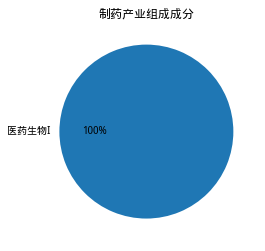

成分股:7支
188    华大基因
189    海王生物
190    达安基因
191    鱼跃医疗
192    蓝帆医疗
193    以岭药业
194    红日药业
Name: NAME, dtype: object
—————————————————————————————————————————————————————


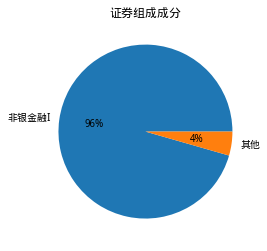

成分股:45支
195    申万宏源
196    国元证券
197    广发证券
198    长江证券
199    西部证券
200    国信证券
201    长城证券
202     同花顺
203    东方财富
204    中信证券
205    国投资本
206    国金证券
207    西南证券
208    五矿资本
209    中航产融
210    海通证券
211    东方证券
212    招商证券
213    中信建投
214    财通证券
215    天风证券
216    东兴证券
217    国泰君安
218    中国人保
219    兴业证券
220    东吴证券
221    华泰证券
222    光大证券
223    浙商证券
224    中国银河
225    方正证券
226    南京证券
227    陕国投A
228    东北证券
229    国海证券
230    山西证券
231    国盛金控
232    第一创业
233    华西证券
234    九鼎投资
235    华创阳安
236    金证股份
237    爱建集团
238    华安证券
239     太平洋
Name: NAME, dtype: object
—————————————————————————————————————————————————————


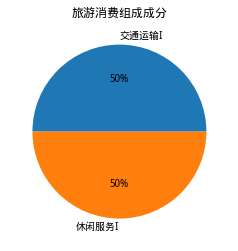

成分股:6支
240    宋城演艺
241    白云机场
242    上海机场
243    春秋航空
244    首旅酒店
245    锦江酒店
Name: NAME, dtype: object
—————————————————————————————————————————————————————


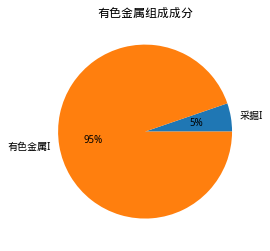

成分股:19支
246    北方稀土
247    江西铜业
248    紫金矿业
249    洛阳钼业
250    中金岭南
251    中色股份
252    云铝股份
253    云南铜业
254    锡业股份
255    中科三环
256     格林美
257    寒锐钴业
258    广晟有色
259    西藏珠峰
260    盛和资源
261    驰宏锌锗
262    山煤国际
263    厦门钨业
264    西部矿业
Name: NAME, dtype: object
—————————————————————————————————————————————————————


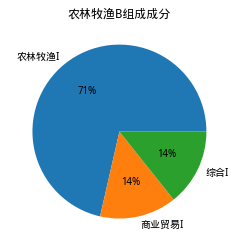

成分股:7支
265     农产品
266    中粮科技
267    隆平高科
268     北大荒
269    中粮糖业
270    东方集团
271    海南橡胶
Name: NAME, dtype: object
—————————————————————————————————————————————————————


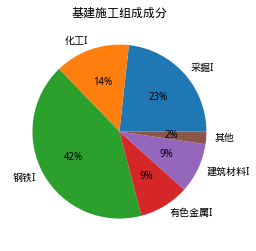

成分股:43支
272    中信特钢
273    荣盛石化
274    龙佰集团
275    包钢股份
276    宝钢股份
277    中国巨石
278    陕西煤业
279    中国铝业
280    中海油服
281    冀东水泥
282    晨鸣纸业
283    攀钢钒钛
284    铜陵有色
285    河钢股份
286    韶钢松山
287    太钢不锈
288    天山股份
289    鞍钢股份
290    华菱钢铁
291    冀中能源
292    首钢股份
293    山西焦煤
294    三钢闽光
295    电投能源
296    塔牌集团
297    山东钢铁
298    兖矿能源
299    南山铝业
300    广汇能源
301    南钢股份
302    酒钢宏兴
303    华阳股份
304    方大特钢
305    华谊集团
306    新钢股份
307    华新水泥
308    马钢股份
309    淮北矿业
310    柳钢股份
311    重庆钢铁
312    潞安环能
313    金钼股份
314     新凤鸣
Name: NAME, dtype: object
—————————————————————————————————————————————————————


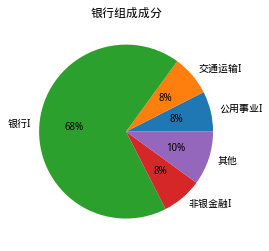

成分股:40支
315    平安银行
316    宁波银行
317    浦发银行
318    华能国际
319    华夏银行
320    民生银行
321    中国石化
322    招商银行
323    国投电力
324    长江电力
325    江苏银行
326    杭州银行
327    大秦铁路
328    南京银行
329    中国神华
330    兴业银行
331    北京银行
332    上海银行
333    农业银行
334    中国平安
335    交通银行
336    工商银行
337    长沙银行
338    中国太保
339    中国人寿
340    中国建筑
341    光大银行
342    成都银行
343    中国石油
344    建设银行
345    中国银行
346    中信银行
347    江阴银行
348    张家港行
349    郑州银行
350    建发股份
351    山东高速
352    无锡银行
353    常熟银行
354    贵阳银行
Name: NAME, dtype: object
—————————————————————————————————————————————————————


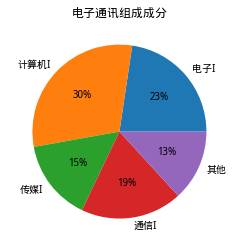

成分股:53支
355    中兴通讯
356    京东方A
357    浪潮信息
358    石基信息
359    科大讯飞
360    大华股份
361    航天信息
362    亨通光电
363    烽火通信
364    中天科技
365    恒生电子
366    工业富联
367     三六零
368    深天马A
369    深圳华强
370    华数传媒
371    常山北明
372     新大陆
373    思源电气
374    国脉科技
375    利欧股份
376    广电运通
377    二三四五
378     天融信
379     合力泰
380     卫士通
381    光迅科技
382    千方科技
383     维信诺
384    星网锐捷
385     爱施德
386    海格通信
387     海能达
388     木林森
389     机器人
390    三聚环保
391    华策影视
392     易华录
393     利亚德
394    歌华有线
395    国网信通
396    中文传媒
397    浙数文化
398    彩虹股份
399    东软集团
400    佳都科技
401    东方通信
402    四川长虹
403    长飞光纤
404     人民网
405    景旺电子
406    依顿电子
407     新华网
Name: NAME, dtype: object
—————————————————————————————————————————————————————


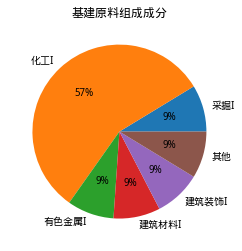

成分股:23支
408    美锦能源
409    浙江龙盛
410     南玻A
411    鲁西化工
412    诚志股份
413    鸿达兴业
414    中泰化学
415    劲嘉股份
416    大洋电机
417    西部建设
418    闰土股份
419    卫星化学
420    新疆交建
421    兴发集团
422    巨化股份
423    嘉化能源
424    三友化工
425    方大炭素
426    中铝国际
427    桐昆股份
428    海南矿业
429    合盛硅业
430    彤程新材
Name: NAME, dtype: object
—————————————————————————————————————————————————————


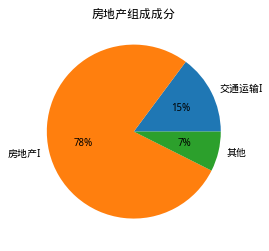

成分股:27支
431     万科A
432    华侨城A
433    金科股份
434     阳光城
435    中南建设
436    招商蛇口
437    荣盛发展
438    南方航空
439    保利发展
440    中国东航
441    华夏幸福
442    金地集团
443    绿地控股
444    中国国航
445    新城控股
446    中国铁建
447    新华保险
448     大悦城
449     金融街
450    泰禾集团
451    滨江集团
452    华发股份
453    首开股份
454    蓝光发展
455    信达地产
456    世茂股份
457    吉祥航空
Name: NAME, dtype: object
—————————————————————————————————————————————————————


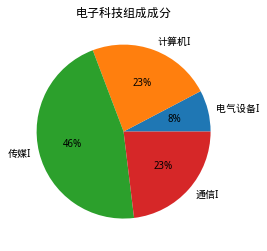

成分股:13支
458    神州泰岳
459    网宿科技
460    蓝色光标
461    顺网科技
462    大富科技
463    东方国信
464    捷成股份
465    掌趣科技
466    旋极信息
467     易事特
468     汤姆猫
469     新国脉
470     鹏博士
Name: NAME, dtype: object
—————————————————————————————————————————————————————


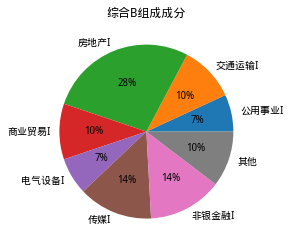

成分股:29支
471    万达电影
472    新湖中宝
473    广汇汽车
474    东方明珠
475    上海临港
476    君正集团
477    泛海控股
478    天健集团
479    渤海租赁
480    中天金融
481    启迪环境
482    传化智联
483     怡亚通
484    中粮资本
485     富森美
486     碧水源
487    南京高科
488    浙江东方
489    中体产业
490    平高电气
491    小商品城
492    国网英大
493    浦东金桥
494    上实发展
495    中储股份
496    百联股份
497    张江高科
498    江苏有线
499    中信重工
Name: NAME, dtype: object
—————————————————————————————————————————————————————


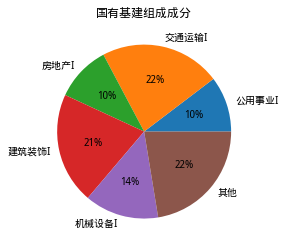

成分股:58支
500    徐工机械
501    天茂集团
502    上港集团
503    华电国际
504    中国联通
505     葛洲坝
506    中国化学
507    中国中铁
508    中国中冶
509    中国电建
510    中国中车
511    中国交建
512    招商轮船
513    中远海控
514    神州高铁
515    深圳能源
516    中集集团
517      柳工
518    广宇发展
519    皖能电力
520    建投能源
521    吉林敖东
522    中山公用
523    宝新能源
524    苏宁环球
525    新兴铸管
526    招商港口
527    中工国际
528     金螳螂
529    中远海能
530    四川路桥
531     大名城
532    城建发展
533    中油工程
534    中化国际
535    中铁工业
536    山鹰国际
537    淮河能源
538    天地科技
539     外高桥
540    城投控股
541    物产中大
542     天津港
543    厦门国贸
544    隧道股份
545    石化油服
546    亚泰集团
547    江苏租赁
548    中材国际
549     唐山港
550    中国一重
551     广州港
552    广深铁路
553    中国核建
554     美凯龙
555    中远海发
556    辽港股份
557    金隅集团
Name: NAME, dtype: object
—————————————————————————————————————————————————————


In [158]:
stockNames = ['医药生物A','食品饮料' ,'综合A', '电子制造', '医药生物B', 
              '建材', '汽车', '传媒互娱', '集成电子',
             '农林牧渔A', '家居服务', '国防军工', '制药产业', '证券', 
              '旅游消费', '有色金属', '农林牧渔B', '基建施工', '银行', '电子通讯',
             '基建原料', '房地产', '电子科技', '综合B', '国有基建']  
draw(stockClass)

本次聚类的过程中剔除了$170$支股票，然后将沪深$300$和中证$500$划分成了$25$个类，类内的平均相关系数为$0.507702$，最低的相关系数为阈值$0.4$，最高的相关系数达到了$0.709515$，可见本次聚类的结果还是比较紧密的。

我们根据每一类的组成分来对聚类结果进行命名，定义若在该类中某行业占比超过0.4，则命名该类为该行业，若均未超过$0.4$，则命名为综合类别，得到$25$个类的名字如下。

In [26]:
swchange = []
for i in swClass:
    price = get_price(i, start_date=startDate, end_date=endDate, 
                            frequency=str(feq+1)+'d',fields='close',skip_paused=False,
                          fq='pre',count=count).close.dropna(axis=1,how='any')
    price = price.values.T
    change = []
    for i in price:
        change.append(np.log(i[1:]/i[:-1]))
    swchange.append(change)
swcorr,meanswcorr = GetCorr(swchange)
print('平均相关系数：',meanswcorr)
sw = pd.DataFrame({'申万行业':industryName,'相关系数':swcorr})
sw

平均相关系数： 0.3829303809406575


,申万行业,相关系数
0,农林牧渔I,0.327075
1,采掘I,0.432625
2,化工I,0.314501
3,钢铁I,0.546511
4,有色金属I,0.386540
5,电子I,0.388233
6,家用电器I,0.302815
7,食品饮料I,0.328437
8,纺织服装I,0.274785
9,轻工制造I,0.303886


申万行业内部的平均组内相关系数为0.3829，比本文聚类结果低，不少申万一级行业内部相关系数小于0.4，过于松散。所以有理由相信我们的聚类效果在紧密程度上比申万行业要好。并且可以猜测有很多特别的股票虽然根据主营业务被划分在该申万行业中，但起表现行为却与另外一行业相似，我们的聚类结果中可以筛选出这样的股票，即我们的聚类结果更加具有真实意义，也更加客观。